In [1]:
import numpy as np
%matplotlib inline
from datavyz.main import graph_env

In [96]:
ge = graph_env('visual_stim')

In [97]:
# parameters of the model

model = {
    # units of the visual field is degree
    'screen_width':16./9.*30, # degree
    'screen_height':30.,
    'screen_dpd':5, # dot per degree
    # receptive fields
    'rf_seed':1,
    'size':2,
    # temporal filtering
    'tau_adapt':300e-3,
    'tau_delay':30e-3,
    'fraction_adapt':0.7,
    # numerical simulations
    'dt':1e-3,
    'tstop':1.,
}

# Visual setting

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0ede4790>)

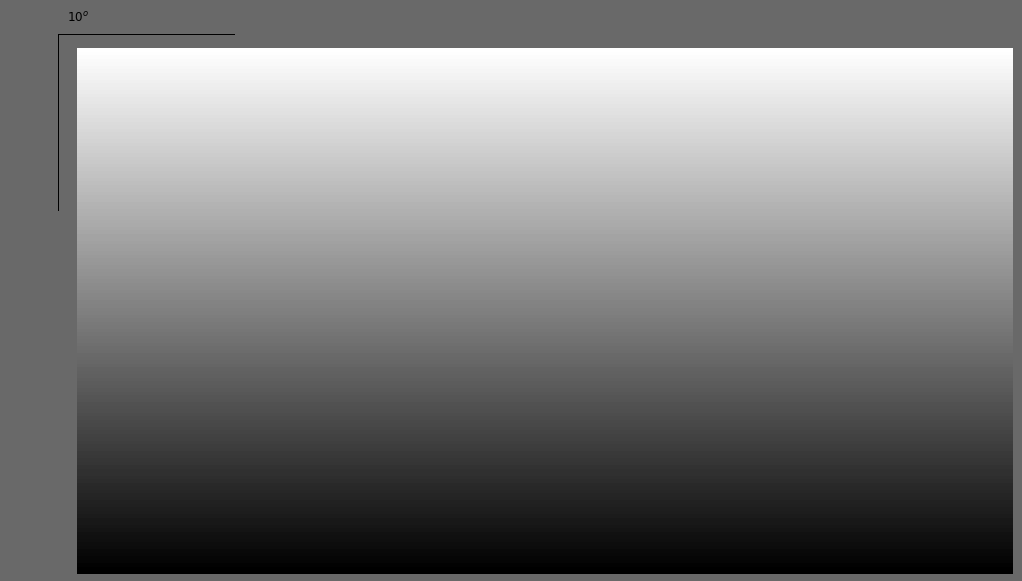

In [4]:




SCREEN = {'width':16./9.*30, # degree
          'height':30.,
          'dpd':5} # dot per degree
SCREEN['Xd_max'] = int(model['screen_width']*model['screen_dpd'])
SCREEN['Yd_max'] = int(model['screen_height']*model['screen_dpd'])
SCREEN['xd_1d'], SCREEN['yd_1d'] = np.arange(SCREEN['Xd_max']), np.arange(SCREEN['Yd_max'])
SCREEN['xd_2d'], SCREEN['yd_2d'] = np.meshgrid(SCREEN['xd_1d'], SCREEN['yd_1d'], indexing='ij')
SCREEN['x_1d'], SCREEN['y_1d'] = SCREEN['xd_1d']/SCREEN['dpd'], SCREEN['yd_1d']/SCREEN['dpd']
SCREEN['x_2d'], SCREEN['y_2d'] = np.meshgrid(SCREEN['x_1d'], SCREEN['y_1d'], indexing='ij')

def plot(Z,
         ax=None,
         Ybar_label='',
         Xbar_label='10$^o$'):
    if ax is None:
        fig, ax = ge.figure()
    else:
        fig = None
    ge.twoD_plot(SCREEN['x_2d'].flatten(),
                 SCREEN['y_2d'].flatten(),
                 1.-Z.flatten(),
                 vmin=0, vmax=1,
                 colormap=ge.binary,
                 ax=ax)
    ge.draw_bar_scales(ax, Xbar=10., Ybar_label=Ybar_label,
                       Ybar=10., Xbar_label=Xbar_label,
                       xyLoc=(-0.02*model['screen_width'], 1.02*model['screen_height']),
                       loc='left-top')
    ax.axis('equal')
    ax.axis('off')
    return fig, ax

plot(SCREEN['y_2d']/SCREEN['y_2d'].max())

# Cells with gabor receptive fields

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0e8291d0>)

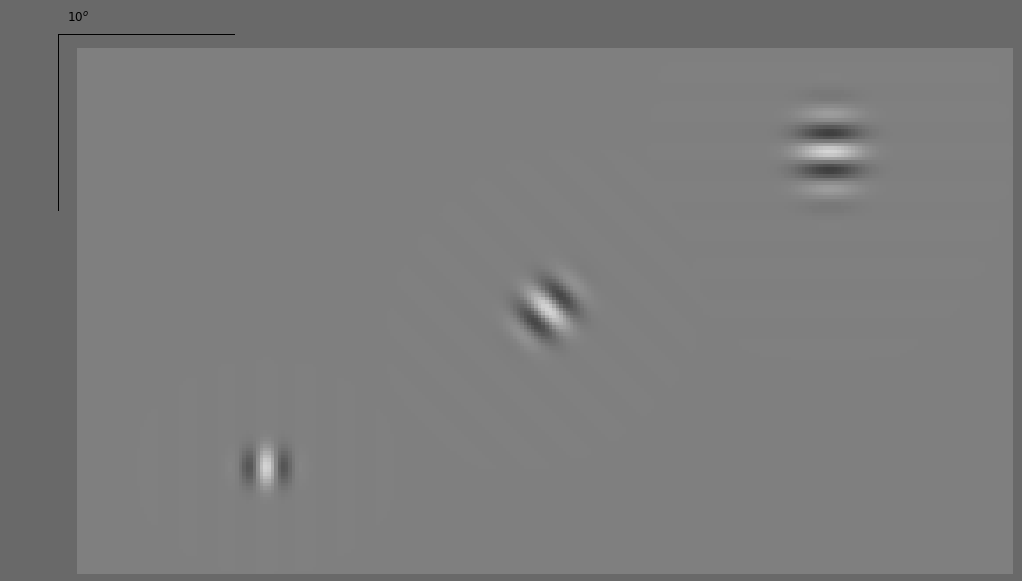

In [79]:
from gabor_filters import gabor


N=3 # picking 10 cells

RANGES = {'x0':[0.2*SCREEN['width'], 0.8*SCREEN['width']],
          'y0':[0.2*SCREEN['height'], 0.8*SCREEN['height']],
          'freq':[1./(0.05*SCREEN['height']), 1./(0.1*SCREEN['height'])],
          'size':[0.02*SCREEN['height'], 0.1*SCREEN['height']],
          'beta':[1., 2.],
          'theta':[0., np.pi/2.],
          'psi':[0., np.pi]}
RANGES = {'x0':[0.2*SCREEN['width'], 0.8*SCREEN['width']],
          'y0':[0.2*SCREEN['height'], 0.8*SCREEN['height']],
          'freq':np.ones(2)/(0.075*SCREEN['height']),
          'size':[0.03*SCREEN['height'], 0.05*SCREEN['height']],
          'beta':[1.5, 1.5],
          'theta':[0, np.pi/2.],
          'psi':[0., 0]}

CELLS = {}
for icell, key in enumerate(RANGES):
    # CELLS[key] = np.random.uniform(RANGES[key][0], RANGES[key][1], size=N)
    CELLS[key] = np.linspace(RANGES[key][0], RANGES[key][1], N)

Z = 0*SCREEN['x_2d']

def cell_gabor(i, CELLS, SCREEN,
               x_shift=0.,
               y_shift=0.,
               normalized=False,
               width_factor=2., # to determine the center condition
               with_center_conditions=False):
    
    gb = gabor(SCREEN['x_2d'], SCREEN['y_2d'],
               x0=CELLS['x0'][i]+x_shift,
               y0=CELLS['y0'][i]+y_shift,
               freq=CELLS['freq'][i],
               size=CELLS['size'][i],
               beta=CELLS['beta'][i],
               theta=CELLS['theta'][i],
               psi=CELLS['psi'][i])

    if with_center_conditions:
        
        # find x-y boundaries, including the possible shift in visual space
        cond_x = (SCREEN['x_1d']>=CELLS['x0'][i]+x_shift-width_factor*CELLS['size'][i]) &\
            (SCREEN['x_1d']<CELLS['x0'][i]+x_shift+width_factor*CELLS['size'][i])
        cond_y = (SCREEN['y_1d']>=CELLS['y0'][i]+y_shift-width_factor*CELLS['size'][i]) &\
            (SCREEN['y_1d']<CELLS['y0'][i]+y_shift+width_factor*CELLS['size'][i])

        if normalized:
            # norm_factor = convolution_function(gb[cond_x, cond_y], gb[cond_x, cond_y])
            norm_factor = convolution_function(gb, gb)
        else:
            norm_factor = 1.
        
        
        return gb/norm_factor, cond_x, cond_y

    else:
        if normalized:
            norm_factor = convolution_function(gb, gb)
        else:
            norm_factor = 1.
    
        return gb/norm_factor
    
    
for i in range(N):
    z = cell_gabor(i, CELLS, SCREEN)+0.5
    Z += z/N

plot(Z)    


# Stimuli: 1) Drifting gratings

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0e7cb650>)

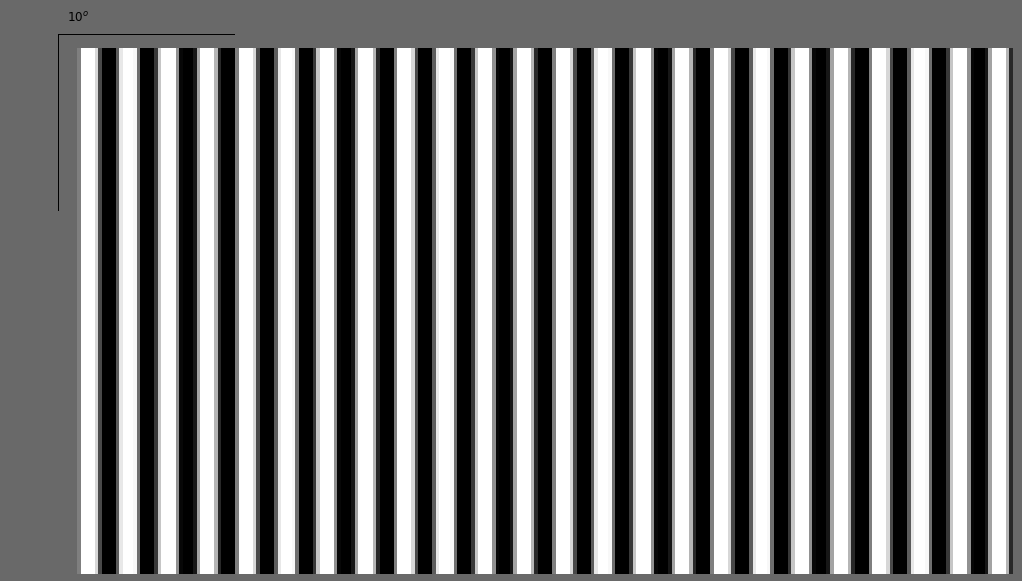

In [59]:
spatial_freq, theta = CELLS['freq'][0], CELLS['theta'][0]

# Centering and Rotation
x_theta = SCREEN['x_2d'] * np.cos(theta) + SCREEN['y_2d'] * np.sin(theta)
y_theta = -SCREEN['x_2d'] * np.sin(theta) + SCREEN['y_2d'] * np.cos(theta)


Z = np.sin(2*np.pi*spatial_freq*x_theta)+.5

plot(Z)


# Linear filtering

In [80]:
import itertools

# build_iterator
def convolution_function(array1, array2):
    tot = 0
    for i, j in itertools.product(range(array1.shape[0]), range(array1.shape[1])):
        tot += array1[i,j]*array2[i,j]
    return tot

def convol_func_gabor_restricted(array, icell, CELLS, SCREEN,
                                 x_shift=0,
                                 y_shift=0,
                                 width_factor=2.):

    # compute gabor filter of cell icell, with the gaze-shift
    gb, cond_x, cond_y = cell_gabor(icell, CELLS, SCREEN,
                                    x_shift=x_shift, y_shift=y_shift,
                                    normalized=True,
                                    with_center_conditions=True)

    iterator = itertools.product(SCREEN['xd_1d'][cond_x], SCREEN['yd_1d'][cond_y])
    
    if array.shape==gb.shape:
        tot = 0
        for i, j in iterator:
            tot += gb[i,j]*array[i,j]
    elif array[0, :, :].shape==gb.shape:
        tot = np.zeros(array.shape[0])
        for it in len(tot):
            for i, j in iterator:
                tot[it] += gb[i,j]*array[it, i, j]
    else:
        print('uable to match array shape')
        tot=None

    return tot

In [81]:
CELLS = {'x0':[30,30],
         'y0':[15,25],
         'freq':np.ones(2)/(0.075*SCREEN['height']),
         'size':[1, 1],
         'beta':[1.5, 1.5],
         'theta':[0, 0],
         'psi':[0., 0]}
# checking the convolution function
gb1, gb2 = cell_gabor(0, CELLS, SCREEN), cell_gabor(1, CELLS, SCREEN)
print(convol_func_gabor_restricted(gb1, 0, CELLS, SCREEN))
print(convolution_function(gb1, gb1))
# Let's present gb2 on the screen, and check that a shifted gb1 matches
#plot(gb1+.5)
#plot(gb2+.5) 
print(convol_func_gabor_restricted(gb2, 0, CELLS, SCREEN))
print(convol_func_gabor_restricted(gb2, 0, CELLS, SCREEN, y_shift=10))

0.9921004561066805
32.07690698301965
1.753258988288381e-24
0.9921004561066804


(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0c068c90>)

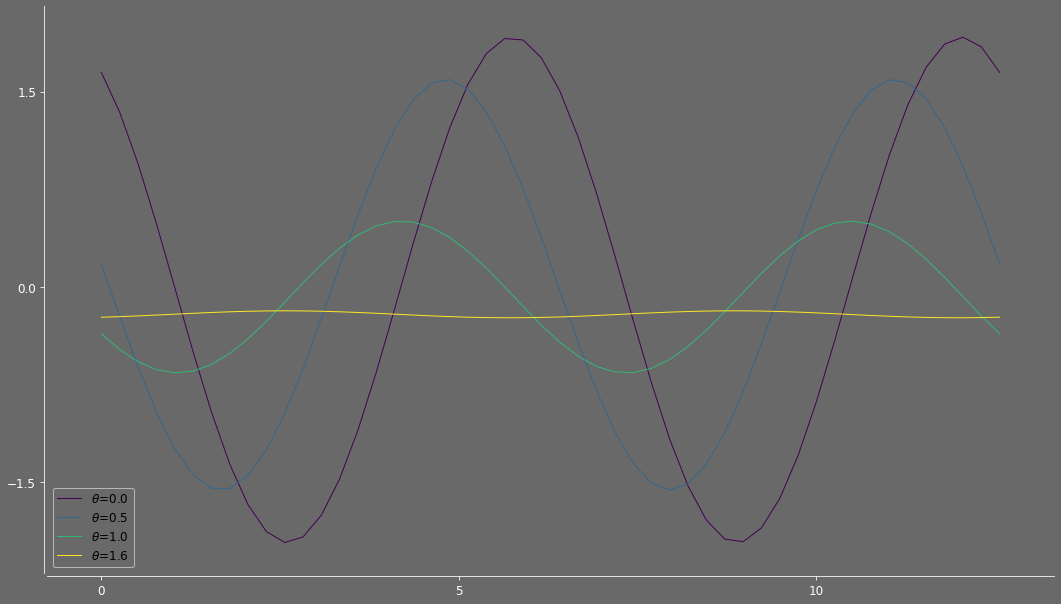

In [87]:
N=4
CELLS = {'x0':30*np.ones(N),
         'y0':30*np.ones(N),
         'freq':np.ones(N)/(0.075*SCREEN['height']),
         'size':np.ones(N),
         'beta':1.5*np.ones(N),
         'theta':np.linspace(0, np.pi/2., N),
         'psi':np.zeros(N)}

t = np.linspace(0, 1, 50)# in seconds
PHASES = 4*np.pi*t
LF = [[] for i in range(N)]

spatial_freq, theta = CELLS['freq'][0], CELLS['theta'][0]

# Centering and Rotation
x_theta = SCREEN['x_2d'] * np.cos(theta) + SCREEN['y_2d'] * np.sin(theta)

for phase in PHASES:
    Z = np.sin(2*np.pi*spatial_freq*x_theta+phase)+.5
    for i in range(N):
        LF[i].append(convol_func_gabor_restricted(Z, i, CELLS, SCREEN))
    
ge.plot(PHASES, Y=LF, LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={})

# Non-linear processing

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79fee5fad0>)

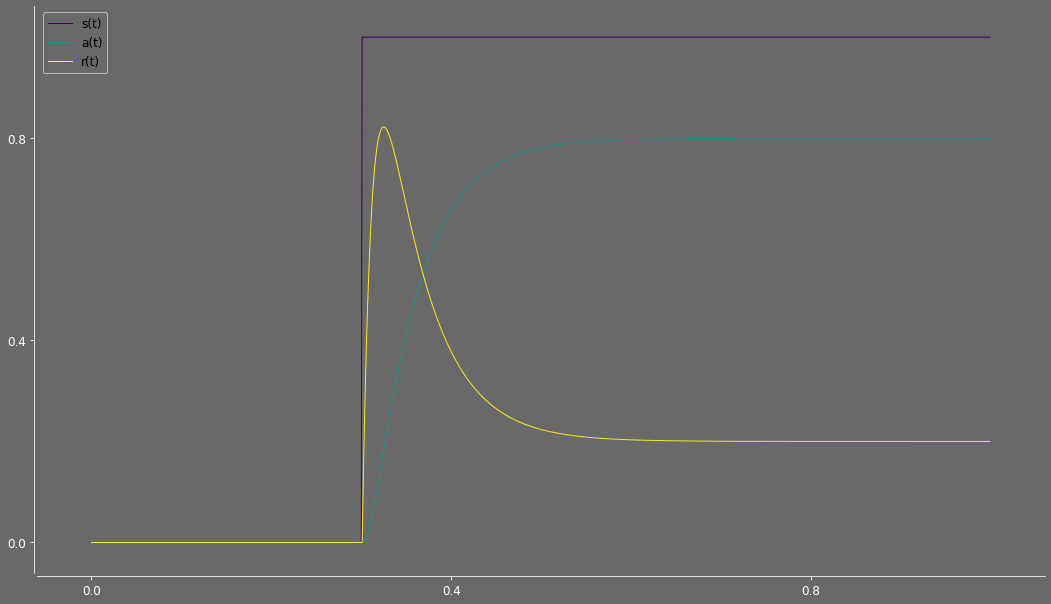

In [90]:

tstop, dt = 1, 1e-3
tau_delay, tau_adapt = 10e-3, 300e-3
fraction_adapt = 0.2

t = np.arange(int(tstop/dt))*dt

s = [1 if tt>tau_adapt else 0 for tt in t]

r = np.zeros(len(t))
a = np.zeros(len(t))

def operator_delay_adapt(s, a, r,
                         model):
    """
    rr[i+1= r[i]+dt/tau_delay*(-r[i]+s[i]-a[i])
    
  a[i]+dt/tau_adapt*((1-fraction_adapt)/fraction_adapt*r[i]-a[i])
    """
    return [r+model['dt']/model['tau_delay']*(-r+s-a),
            a+model['dt']/model['tau_delay']*((1-model['fraction_adapt'])/model['fraction_adapt']*r-a)]


for i in range(1, len(t)-1):
    r[i+1], a[i+1] = 

ge.plot(t, Y=[s,a,r], LABELS=['s(t)','a(t)','r(t)'], legend_args={})


(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79fedc2f50>)

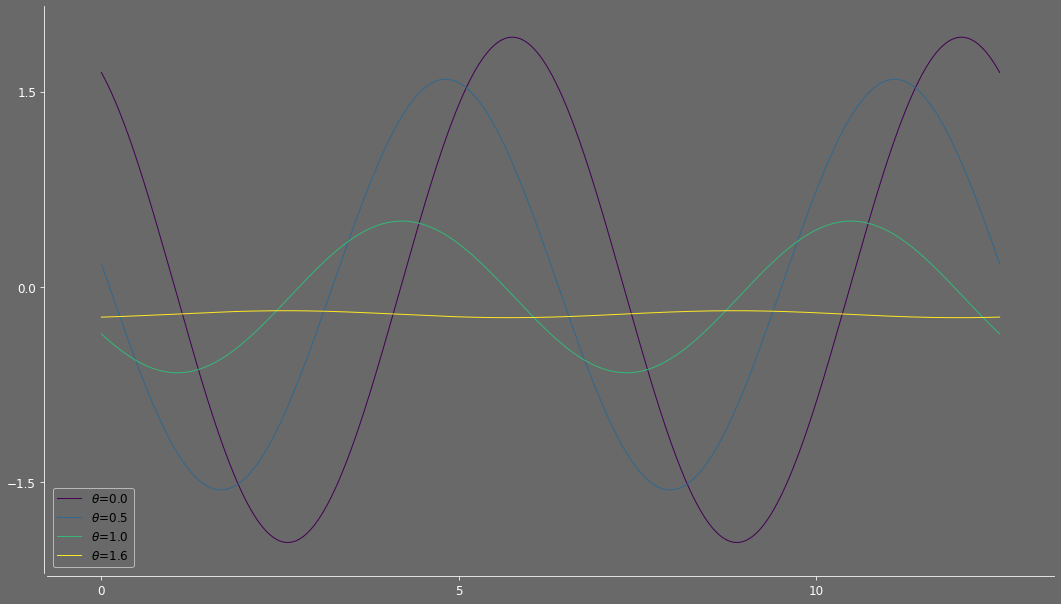

In [92]:
t = np.linspace(0, 1, int(tstop/dt))# in seconds
PHASES = 4*np.pi*t

LF = [[] for i in range(N)]

for phase in PHASES:
    Z = np.sin(2*np.pi*spatial_freq*x_theta+phase)+.5
    for i in range(N):
        LF[i].append(convol_func_gabor_restricted(Z, i, CELLS, SCREEN))
    
ge.plot(PHASES, Y=LF, LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={})


(<Figure size 831.685x572.598 with 2 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f1950a7e9d0>)

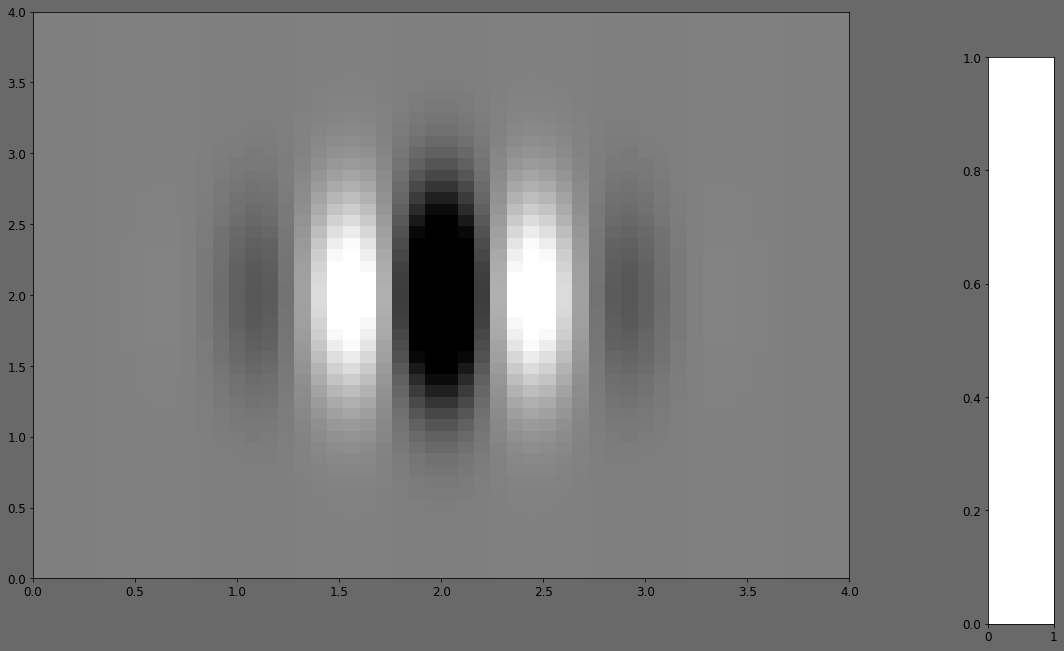

In [11]:
x, y = np.meshgrid(np.linspace(0, 4), np.linspace(0, 4))
z = gabor(x, y, x0=2 ,y0=2)
ge.twoD_plot(x.flatten(), y.flatten(), z.flatten()+0.5, vmin=0, vmax=1, colormap=ge.binary)
